# AI-Based Road Cleanliness Assessment System using Image  Classification

TThis project aims to classify images of roads as either clean or cluttered using machine learning techniques. Initially, the classification is performed using Support Vector Machine (SVM), a traditional machine learning model. Subsequently, the accuracy is enhanced through optimization using Convolutional Neural Network (CNN) models trained on a dataset of road images. The final model is deployed using Gradio for real-time interaction.

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
! pip install gradio --quiet

In [41]:
#Import Dependencies
# OpenCV for image processing
import cv2
# Library to determine the type of image file
import imghdr
# SQLite for database operations
import sqlite3
# NumPy for numerical computations
import numpy as np
# Functions for reading and resizing images
from skimage.io import imread
from skimage.transform import resize
# Module for handling input/output operations
import io
# Pandas for data manipulation
import pandas as pd
# Module for splitting data into training and testing sets
from sklearn.model_selection import train_test_split
# Support Vector Machine implementation from scikit-learn
from sklearn import svm
# GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
# Metrics functions for model evaluation
from sklearn.metrics import accuracy_score, classification_report
# Module for plotting graphs and visualizations
import matplotlib.pyplot as plt
# TensorFlow for building neural network models
import tensorflow as tf
# Sequential model for stacking layers
from tensorflow.keras.models import Sequential
# Layers for convolutional neural networks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# Metrics for evaluating neural network models
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
# Importing the Adam optimizer from Keras for adjusting hyperparameters during model training
from keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
# Gradio for deploying CNN model.
import gradio as gr

## Data Retrieval from Database and data preprocessing:
This section of the code snippet establishes a connection to a SQLite database containing images of roads categorized as either clean or cluttered. It fetches these images along with their corresponding labels from the database for further processing.

In [64]:
# Connect to SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/clean_cluttered_road.db')
cursor = conn.cursor()

# Function to fetch images and labels from database
def fetch_images_and_labels(table_name, label):
    cursor.execute(f'SELECT image FROM {table_name}')
    rows = cursor.fetchall()
    images = []
    for row in rows:
        img_bytes = np.frombuffer(row[0], dtype=np.uint8)
        img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
        images.append(img)
    labels = [label] * len(images)
    return images, labels

# Fetch images and labels for clean road
clean_images, clean_labels = fetch_images_and_labels('clean_road', label=0)

# Fetch images and labels for cluttered road
cluttered_images, cluttered_labels = fetch_images_and_labels('cluttered_road', label=1)

# Combine images and labels
images = clean_images + cluttered_images
labels = clean_labels + cluttered_labels

# Shuffle data
combined = list(zip(images, labels))
np.random.shuffle(combined)
images[:], labels[:] = zip(*combined)

# Convert images and labels to TensorFlow tensors
images = tf.convert_to_tensor(images)
labels = tf.convert_to_tensor(labels)

# Define batch size
batch_size = 32

# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

# Optionally, shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size)
# Get the iterator
data_iterator = dataset.as_numpy_iterator()

# Define categories
Categories = ['cluttered', 'clean']

# Arrays to store input data and target labels
flat_data_arr = []  # Input array
target_arr = []     # Output array

# Iterate through each category
for category in Categories:
    print(f'Loading category: {category}')
    # Fetch images from the database for the current category
    cursor.execute(f"SELECT image FROM {category}_road")
    images = cursor.fetchall()
    # Process each image in the category
    for img_data in images:
        # Read image data from bytes and resize
        img_array = imread(io.BytesIO(img_data[0]))  # Assuming image data is stored as bytes
        img_resized = resize(img_array, (256, 256, 3))
        # Flatten the resized image and append to input array
        flat_data_arr.append(img_resized.flatten())
        # Append the index of the current category to target array
        target_arr.append(Categories.index(category))
    print(f'Loaded category: {category} successfully')

# Convert input and target arrays to numpy arrays
flat_data = np.array(flat_data_arr)
target = np.array(target_arr)

# Close database connection
conn.close()

# Print number of classes
num_classes = len(np.unique(labels.numpy()))
print("Number of classes:", num_classes)

Loading category: cluttered
Loaded category: cluttered successfully
Loading category: clean
Loaded category: clean successfully
Number of classes: 2


In [65]:
batch = data_iterator.next()

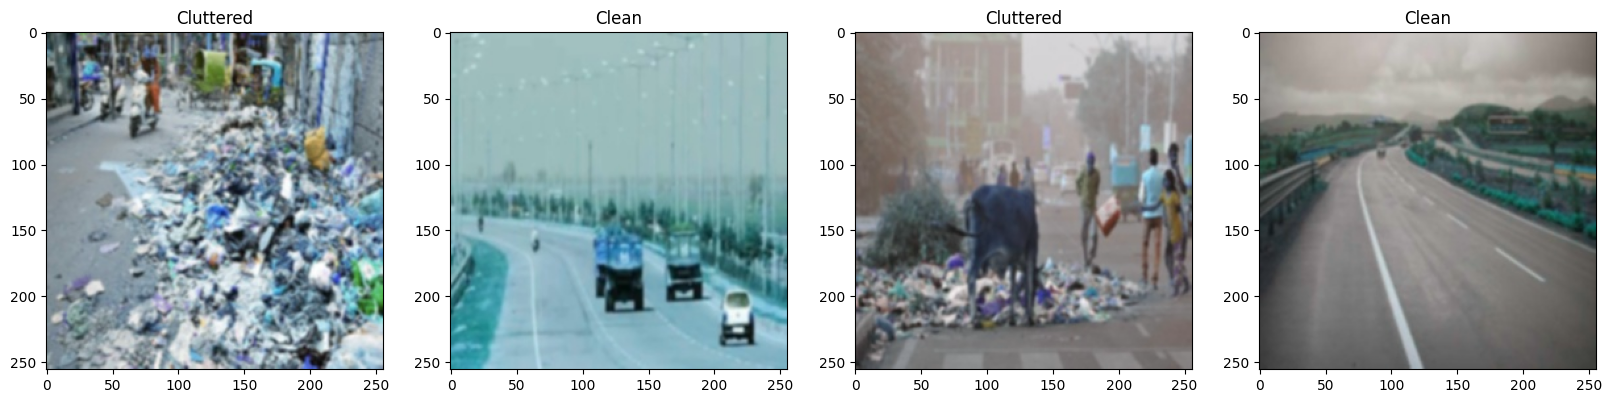

In [66]:
# Mapping of label indices to label names
label_names = {0: 'Clean', 1: 'Cluttered'}

# Convert TensorFlow tensors to NumPy arrays
#images_np = images.numpy()
#labels_np = labels.numpy()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    label_idx = batch[1][idx]
    label_name = label_names.get(label_idx, 'Unknown')  # Get label name from mapping
    ax[idx].set_title(label_name)
plt.show()

## SVM Model:
SVM Model Explanation
Support Vector Machine (SVM) is a supervised learning algorithm used for classification tasks. It works by finding the optimal hyperplane that best separates data points belonging to different classes in a high-dimensional space. Here's an explanation of the key components of the SVM model:

Parameters:

C: Penalty parameter of the error term. It controls the trade-off between maximizing the margin and minimizing the classification error. A smaller value of C leads to a larger margin but may result in more misclassifications, while a larger value of C allows for fewer misclassifications but may lead to a smaller margin.

Gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels. It defines the influence of a single training example, with low values meaning 'far' and high values meaning 'close'. Higher gamma values lead to more complex decision boundaries, potentially overfitting the training data.

Kernel: Specifies the kernel type used in the algorithm ('rbf' for radial basis function, 'poly' for polynomial, etc.).

SVC: The SVC class in scikit-learn implements the SVM algorithm for classification tasks. In this case, probability=True indicates that the model will provide class probabilities along with predictions.

GridSearchCV: GridSearchCV is a technique used for hyperparameter tuning, where a grid of hyperparameters is specified, and the best combination is selected based on cross-validation performance. It systematically searches through the parameter grid, evaluating each combination using cross-validation and selecting the one with the highest performance.

Fitting the Model:

The fit() method of the GridSearchCV object fits the SVM model to the training data (x_train, y_train). During this process, the model iterates through all combinations of hyperparameters specified in param_grid, trains an SVM model with each combination, and selects the best-performing one based on cross-validation scores.

Overall, the SVM model is trained to find the optimal decision boundary that maximizes the margin between different classes while minimizing classification errors. Hyperparameter tuning using techniques like GridSearchCV helps in finding the best combination of hyperparameters for improved model performance on unseen data.


In [45]:
# Create a DataFrame from the flattened data
df = pd.DataFrame(flat_data)

# Add target labels to the DataFrame
df['Target'] = target

# Display the number of rows and columns in the DataFrame
print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (212, 196609)


In [46]:
# Extract input data from DataFrame
x = df.iloc[:, :-1]

# Extract output data from DataFrame
y = df.iloc[:, -1]

In [47]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,
                                               random_state=77,
                                               stratify=y)
x_train

,0,1,2,3,4,5,6,7,8,9,...,196598,196599,196600,196601,196602,196603,196604,196605,196606,196607
98,0.211765,0.403922,0.392157,0.227451,0.392157,0.388235,0.270588,0.380392,0.396078,0.333333,...,0.866667,0.756863,0.835294,0.862745,0.756863,0.831373,0.854902,0.745098,0.819608,0.843137
5,0.533333,0.349020,0.247059,0.529412,0.345098,0.243137,0.525490,0.337255,0.247059,0.529412,...,0.650980,0.654902,0.654902,0.662745,0.674510,0.670588,0.690196,0.686275,0.682353,0.701961
165,0.800000,0.796078,0.858824,0.756863,0.752941,0.815686,0.662745,0.658824,0.729412,0.556863,...,0.913725,0.815686,0.815686,0.909804,0.811765,0.811765,0.905882,0.807843,0.807843,0.901961
170,0.560784,0.560784,0.560784,0.560784,0.560784,0.560784,0.560784,0.560784,0.560784,0.560784,...,0.215686,0.203922,0.200000,0.219608,0.211765,0.207843,0.227451,0.219608,0.215686,0.235294
33,0.180392,0.211765,0.117647,0.180392,0.211765,0.117647,0.184314,0.215686,0.121569,0.196078,...,0.521569,0.517647,0.517647,0.517647,0.517647,0.517647,0.517647,0.517647,0.517647,0.517647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.835294,0.850980,0.862745,0.839216,0.854902,0.866667,0.835294,0.847059,0.866667,0.831373,...,0.588235,0.623529,0.607843,0.596078,0.635294,0.619608,0.607843,0.635294,0.619608,0.607843
6,0.494118,0.596078,0.560784,0.490196,0.596078,0.560784,0.498039,0.603922,0.568627,0.494118,...,0.094118,0.262745,0.156863,0.082353,0.258824,0.133333,0.082353,0.250980,0.117647,0.070588
93,0.258824,0.184314,0.192157,0.305882,0.231373,0.239216,0.423529,0.349020,0.356863,0.529412,...,0.423529,0.619608,0.498039,0.415686,0.647059,0.509804,0.423529,0.654902,0.517647,0.431373
51,0.407843,0.513725,0.588235,0.470588,0.541176,0.596078,0.556863,0.560784,0.580392,0.556863,...,0.529412,0.698039,0.600000,0.521569,0.701961,0.603922,0.525490,0.713725,0.615686,0.537255


In [48]:
# SVM Model
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['rbf', 'poly']}
svc = svm.SVC(probability=True)
model_svm = GridSearchCV(svc, param_grid)

# Testing the model using the testing data
model_svm.fit(x_train,y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

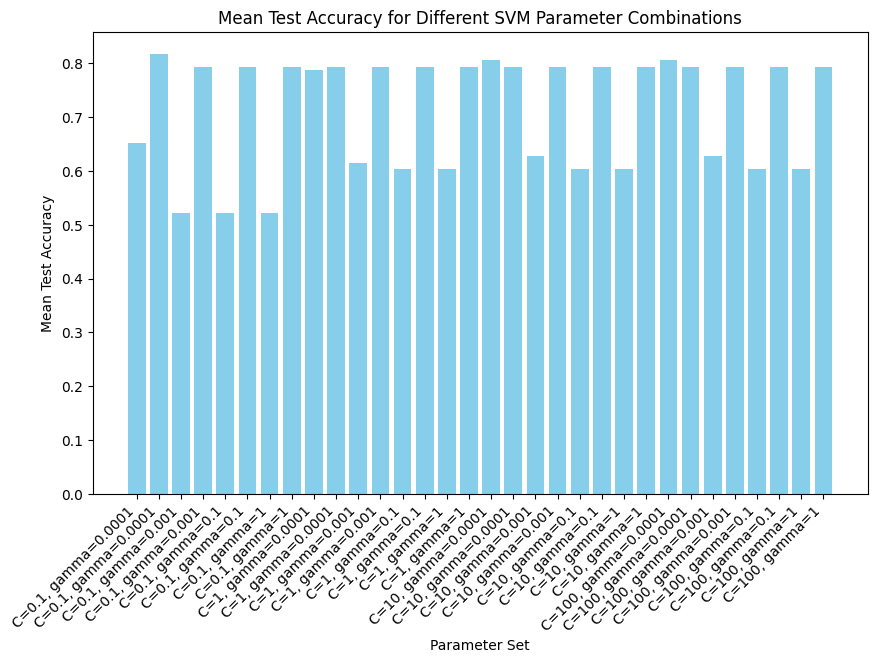

In [49]:
# Extract the mean test scores and parameters from the grid search results
mean_test_scores = model_svm.cv_results_['mean_test_score']
params = model_svm.cv_results_['params']

# Extract C and gamma values from the parameters
C_values = [param['C'] for param in params]
gamma_values = [param['gamma'] for param in params]

# Create a bar plot for accuracy
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_test_scores)), mean_test_scores, color='skyblue')
plt.xlabel('Parameter Set')
plt.ylabel('Mean Test Accuracy')
plt.title('Mean Test Accuracy for Different SVM Parameter Combinations')
plt.xticks(range(len(mean_test_scores)), [f'C={C}, gamma={gamma}' for C, gamma in zip(C_values, gamma_values)], rotation=45, ha='right')
plt.show()

## SVM Model Evaluation
The observed accuracy of 83% for the SVM model falls short of the desired performance threshold, indicating that the model's classification accuracy is not entirely satisfactory. While achieving an accuracy score above chance level suggests some level of discriminatory power, it may not be sufficient for practical applications where higher accuracy is desired. Therefore, given the suboptimal performance of the SVM model, it is prudent to explore optimization strategies, such as leveraging Convolutional Neural Network (CNN) models. CNNs are known for their ability to extract intricate features from image data and can potentially offer superior performance in image classification tasks. By transitioning to a CNN model, there is a greater opportunity to improve accuracy and achieve more reliable results, making it a promising avenue for enhancing the effectiveness of road image classification.*italicized text*

In [50]:
y_pred_svm = model_svm.predict(x_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_pred_svm, y_test)

# Print the accuracy of the model
print(f"The model is {accuracy*100}% accurate")
print(classification_report(y_test, y_pred_svm, target_names=['cluttered', 'clean']))

The model is 83.72093023255815% accurate
              precision    recall  f1-score   support

   cluttered       0.77      0.95      0.85        21
       clean       0.94      0.73      0.82        22

    accuracy                           0.84        43
   macro avg       0.86      0.84      0.84        43
weighted avg       0.86      0.84      0.84        43




## Convolutional Neural Networks (CNNs)

 Convolutional Neural Networks (CNNs) are a class of deep learning models specifically designed for processing structured grid data such as images. Here's an explanation of key components and concepts related to CNNs:

Convolutional Layers: Convolutional layers are the core building blocks of CNNs. They apply a set of learnable filters (also known as kernels) to small regions of the input image, performing a convolution operation. This operation captures local patterns and features, such as edges, textures, and shapes.

Pooling Layers: Pooling layers are used to downsample the spatial dimensions of the feature maps generated by convolutional layers. Common pooling operations include max pooling and average pooling, which reduce the spatial resolution while preserving the most salient features. Pooling helps make the representations more invariant to translation and reduces the computational complexity of subsequent layers.

Activation Functions: Activation functions introduce non-linearity into the CNN, enabling the model to learn complex mappings between input and output. Common activation functions used in CNNs include ReLU (Rectified Linear Unit), which introduces non-linearity by outputting the input if it is positive and zero otherwise.

Fully Connected Layers: After several convolutional and pooling layers, the final feature maps are flattened into a one-dimensional vector and passed through one or more fully connected (dense) layers. These layers combine the learned features from earlier layers to make predictions. The last dense layer typically uses a softmax activation function for multi-class classification tasks, producing probability distributions over different classes.

Training: CNNs are trained using the backpropagation algorithm with gradient descent optimization. During training, the network learns to adjust the weights of its layers to minimize a predefined loss function, such as categorical cross-entropy for classification tasks. This process involves iteratively updating the model parameters based on the gradients of the loss function with respect to the model's parameters.

Overall, CNNs have revolutionized the field of computer vision and have achieved state-of-the-art performance in various image-related tasks, including classification, object detection, segmentation, and more. Their ability to automatically learn hierarchical representations of image data makes them highly effective for a wide range of applications.

In [51]:
data = dataset.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.19215686, 0.18039216, 0.16470588],
          [0.19215686, 0.18039216, 0.16470588],
          [0.19215686, 0.18039216, 0.16470588],
          ...,
          [0.47843137, 0.45882353, 0.44705882],
          [0.48235294, 0.4627451 , 0.45098039],
          [0.48235294, 0.4627451 , 0.45098039]],
 
         [[0.19215686, 0.18039216, 0.16470588],
          [0.19215686, 0.18039216, 0.16470588],
          [0.19215686, 0.18039216, 0.16470588],
          ...,
          [0.47843137, 0.45882353, 0.44705882],
          [0.48235294, 0.4627451 , 0.45098039],
          [0.48235294, 0.4627451 , 0.45098039]],
 
         [[0.19215686, 0.18039216, 0.16470588],
          [0.19215686, 0.18039216, 0.16470588],
          [0.19215686, 0.18039216, 0.16470588],
          ...,
          [0.47843137, 0.45882353, 0.44705882],
          [0.48235294, 0.4627451 , 0.45098039],
          [0.48627451, 0.46666667, 0.45490196]],
 
         ...,
 
         [[0.10196078, 0.09411765, 0.09019608],
          [0.10196

In [59]:
# Define the TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs')

model_cnn= Sequential()

model_cnn.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_cnn.add(MaxPooling2D())
model_cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
model_cnn.add(MaxPooling2D())
model_cnn.add(Conv2D(16, (3,3), 1, activation='relu'))
model_cnn.add(MaxPooling2D())
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Preparing testing and training data for CNN model
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.2)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

## CNN Model Evaluation

The training and validation results indicate the performance of the Convolutional Neural Network (CNN) model:

Training Loss and Accuracy: The training loss measures the difference between the model's predicted outputs and the actual labels during training. A lower training loss indicates better agreement between predictions and ground truth. In this case, the training loss is 0.0742, indicating that the model's predictions are generally close to the actual labels. The training accuracy, which measures the proportion of correctly classified samples in the training set, is 96.09%. This high accuracy suggests that the model has learned to effectively classify road images during training.

Validation Loss and Accuracy: The validation loss and accuracy provide an estimate of the model's performance on unseen data (i.e., the validation set). The validation loss is 0.0363, indicating that the model performs well on unseen data, similar to its performance during training. The validation accuracy is 100%, suggesting that the model generalizes well to new road images and is not overfitting to the training data.

Precision, Recall, and Accuracy: Precision measures the proportion of true positive predictions out of all positive predictions made by the model. Recall measures the proportion of true positive predictions out of all actual positive samples in the dataset. Both precision and recall are 1.0, indicating perfect performance in correctly identifying both clean and cluttered road images. The overall accuracy is also 100%, reflecting the model's high performance across all classes.

Overall, these evaluation metrics demonstrate that the CNN model achieves outstanding performance in classifying road images, with high accuracy, precision, and recall, both during training and on unseen validation data.

In [53]:
# Training the CNN model
epochs = 20
history_cnn = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}  # Dictionary to store history
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    history = model_cnn.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])  # Train for 1 epoch

    # Update history
    history_cnn['loss'].append(history.history['loss'][0])
    history_cnn['accuracy'].append(history.history['accuracy'][0])
    history_cnn['val_loss'].append(history.history['val_loss'][0])
    history_cnn['val_accuracy'].append(history.history['val_accuracy'][0])

# Print loss and accuracy for training and validation
train_loss, train_accuracy = model_cnn.evaluate(train, verbose=0)
val_loss, val_accuracy = model_cnn.evaluate(val, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/20
4/4 [==============================] - 11s 2s/step - loss: 0.8660 - accuracy: 0.5156 - val_loss: 0.7751 - val_accuracy: 0.4062
Epoch 2/20
4/4 [==============================] - 10s 3s/step - loss: 0.7091 - accuracy: 0.4766 - val_loss: 0.6822 - val_accuracy: 0.5625
Epoch 3/20
4/4 [==============================] - 7s 2s/step - loss: 0.6711 - accuracy: 0.5781 - val_loss: 0.6642 - val_accuracy: 0.5938
Epoch 4/20
4/4 [==============================] - 7s 2s/step - loss: 0.6328 - accuracy: 0.7031 - val_loss: 0.5522 - val_accuracy: 0.7500
Epoch 5/20
4/4 [==============================] - 9s 2s/step - loss: 0.5487 - accuracy: 0.7734 - val_loss: 0.5674 - val_accuracy: 0.7500
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: 0.5726 - accuracy: 0.7188 - val_loss: 0.5622 - val_accuracy: 0.7188
Epoch 7/20
4/4 [==============================] - 7s 2s/step - loss: 0.4762 - accuracy: 0.8047 - val_loss: 0.4447 - val_accuracy: 0.8125
Epoch 8/20
4/4 [=======================

In [54]:
# Preparing testing and training data for CNN model
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred_cnn = model_cnn.predict(X)
    pre.update_state(y, y_pred_cnn)
    re.update_state(y, y_pred_cnn)
    acc.update_state(y, y_pred_cnn)

1/1 [==============================] - 1s 665ms/step


In [55]:
print (f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()},Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0,Accuracy: 1.0


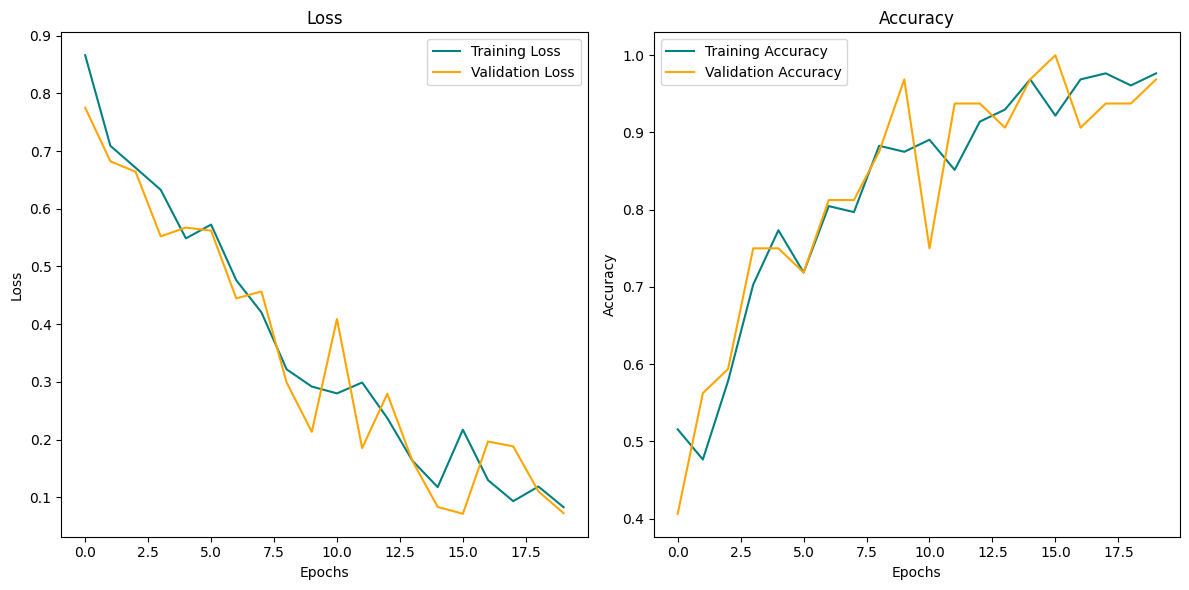

In [56]:
# Plotting the training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn['loss'], color='teal', label='Training Loss')
plt.plot(history_cnn['val_loss'], color='orange', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn['accuracy'], color='teal', label='Training Accuracy')
plt.plot(history_cnn['val_accuracy'], color='orange', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Optimized CNN Model:

The optimization model , CNN, achieves superior accuracy, precision, and recall in classifying road images as clean or cluttered. It demonstrates robustness to various conditions, making it reliable for real-world applications in road condition assessment and maintenance prioritization.

## Deployment with Gradio:

Gradio simplifies the deployment of the CNN model, offering an intuitive interface for users to interact with without coding. This facilitates practical applications such as road condition monitoring and maintenance strategy optimization. Gradio's accessibility makes the CNN model usable for diverse users, regardless of their expertise in machine learning or programming.

** In summary, the optimized CNN model, deployed through Gradio, provides a high-performance, user-friendly solution for evaluating road conditions and guiding maintenance efforts effectively in real-world settings. **

In [61]:
def classify_image_cnn(image):
    img = cv2.resize(image, (256, 256))
    img = img.reshape(1, 256, 256, 3)
    prediction = model_cnn.predict(img)[0][0]
    threshold = 0.5  # Adjust this threshold as needed
    return "\"Clean\", Hooray! This road is squeaky clean!" if prediction >= threshold else "\"Cluttered Road\", Oh no! This road needs cleaning!"

# Create Gradio interface for CNN model
iface_cnn = gr.Interface(
    fn=classify_image_cnn,
    inputs=gr.Image(),
    outputs="text",
    title="CNN Image Classification",
    description="Upload an image to classify it as clean or dirty using CNN."
)

# Launch the CNN interface
iface_cnn.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f756d9fed28db5d284.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
